In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from datasets import Dataset

from transformers import (
    CamembertTokenizer,
    CamembertForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [3]:
df = pd.read_csv("hf://datasets/readerbench/fakenews-climate-fr/fake-fr.csv")

### Encodage en str

In [4]:
label_encoder = LabelEncoder()
df["Label"] = label_encoder.fit_transform(df["Label"])
print("Mapping labels :", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Mapping labels : {'biased': 0, 'fake': 1, 'true': 2}


### Split du dataset & reconversion format pandas pour HF

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label"])

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

### Tokenization

In [6]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

def tokenize(batch):
    return tokenizer(
        batch["Text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1947 [00:00<?, ? examples/s]

Map:   0%|          | 0/487 [00:00<?, ? examples/s]

### Nettoyer les colonnes et format torch

In [7]:
train_dataset = train_dataset.rename_column("Label", "labels")  # torch / HF , accepte labels et non "Label"
test_dataset = test_dataset.rename_column("Label", "labels")

cols_to_keep = ["input_ids", "attention_mask", "labels"]
train_dataset = train_dataset.remove_columns([c for c in train_dataset.column_names if c not in cols_to_keep])
test_dataset = test_dataset.remove_columns([c for c in test_dataset.column_names if c not in cols_to_keep])

train_dataset.set_format("torch")
test_dataset.set_format("torch")

In [8]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["Label"]),
    y=df["Label"]
)
print("Poids de classes =", class_weights)

Poids de classes = [2.58386412 1.27769029 0.54635241]


### Chargement du modèle, metrics, trainer

In [9]:
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base",
    num_labels=len(label_encoder.classes_)
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Metrics 

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="../models/CamemBERT_transformers/results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="../models/CamemBERT_transformers/logs",
    weight_decay=0.01,
    learning_rate=5e-5,
)

#### Trainer custom avec weighted loss

In [12]:
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.class_weights = (
            torch.tensor(class_weights, dtype=torch.float)
            if not isinstance(class_weights, torch.Tensor)
            else class_weights.clone().detach()
            if class_weights is not None
            else None
        )

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = nn.CrossEntropyLoss(
            weight=self.class_weights.to(logits.device)
            if self.class_weights is not None else None
        )

        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


#### trainer 

In [13]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

/tmp/ipykernel_4604/4125839410.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


### Vérification batch

In [ ]:
batch = next(iter(train_dataset))
print("input_ids shape:", batch["input_ids"].shape)  # doit être [batch_size, seq_len]

input_ids shape: torch.Size([256])


### Lancement de l’entraînement

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.706744,0.790554,0.715254
2,No log,0.703295,0.786448,0.715795
3,0.671300,0.999932,0.792608,0.700703


TrainOutput(global_step=732, training_loss=0.5759510915787494, metrics={'train_runtime': 136.073, 'train_samples_per_second': 42.925, 'train_steps_per_second': 5.379, 'total_flos': 768422736474624.0, 'train_loss': 0.5759510915787494, 'epoch': 3.0})

### Prédiction sur le dataset de test

In [ ]:
predictions = trainer.predict(test_dataset)

logits = predictions.predictions

true_labels = predictions.label_ids

pred_labels = np.argmax(logits, axis=1)

print("True labels :", true_labels[:10])
print("Predicted labels :", pred_labels[:10])

True labels : [0 2 1 1 2 1 2 0 2 2]
Predicted labels : [1 2 1 1 2 1 2 2 2 2]


### Convertir les indices en labels textuel

In [ ]:
pred_labels_str = label_encoder.inverse_transform(pred_labels)
true_labels_str = label_encoder.inverse_transform(true_labels)

print("True labels :", true_labels_str[:10])
print("Predicted labels :", pred_labels_str[:10])

### Calculer les métriques (accuracy, recall, precision, F1, F1 Macro)

In [ ]:
acc = accuracy_score(true_labels, pred_labels)
f1_macro = f1_score(true_labels, pred_labels, average="macro")
print("Accuracy :", acc)
print("F1 Macro :", f1_macro)

# Rapport complet
print("\nClassification report :")
print(classification_report(true_labels, pred_labels, target_names=label_encoder.classes_))

Accuracy : 0.7926078028747433
F1 Macro : 0.7007029076661572

Classification report :
              precision    recall  f1-score   support

      biased       0.50      0.46      0.48        63
        fake       0.79      0.72      0.75       127
        true       0.85      0.90      0.87       297

    accuracy                           0.79       487
   macro avg       0.71      0.69      0.70       487
weighted avg       0.79      0.79      0.79       487



#### Matrice de confusion

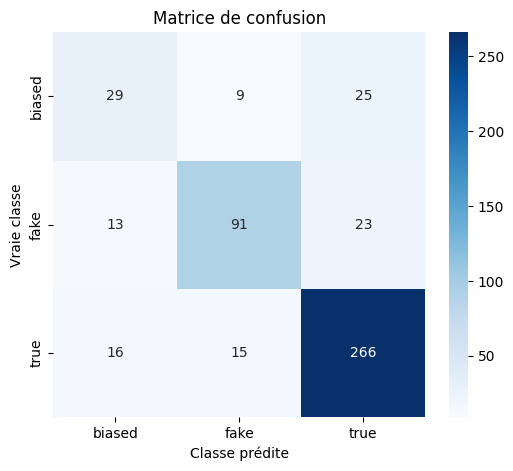

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)
class_names = label_encoder.classes_

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, 
    annot=True,          # Affiche les nombres dans les cases
    fmt="d",             # Format entier
    cmap="Blues",        # Couleur de la heatmap
    xticklabels=class_names,
    yticklabels=class_names
)
plt.ylabel("Vraie classe")
plt.xlabel("Classe prédite")
plt.title("Matrice de confusion")
plt.show()